In [93]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from statistics import mode

In [94]:
def Likelihood(mu,n,b,s):
    
    l = mu*s + b
    
    L = np.exp( -l ) * l**n / np.math.factorial(int(n))
    
    return L

In [95]:
def LogPrior(p):
    
    mu = p
    
    if mu >= 0.:
        return 0.
    else:
        return -np.inf

In [96]:
def JointLogLikelihood(mu,data):
    
    N = data.shape[0]
    
    n = data[:,0]
    b = data[:,1]
    s = data[:,2]
    
    JointL = 0.
    
    for c in range(N):
        JointL += np.log(Likelihood(mu,n[c],b[c],s[c]))
        
    return JointL

In [97]:
def LogPosterior(p,data):
    
    LogP = LogPrior(p)
    
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return JointLogLikelihood(p,data) + LogP

In [116]:
n = np.array([3,8,8])
b = np.array([3,4,5])
s = np.array([1,3,3])

N = n.shape[0]

data = np.zeros((N,3))

data[:,0] = n
data[:,1] = b
data[:,2] = s

data

array([[3., 3., 1.],
       [8., 4., 3.],
       [8., 5., 3.]])

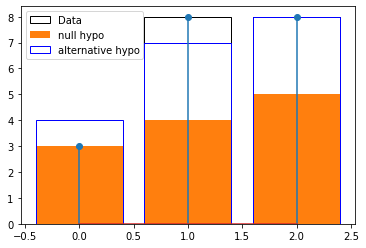

In [117]:
plt.bar(np.arange(0,N,1),n,ec='k',fill=False,label='Data')
plt.stem(n)
plt.bar(np.arange(0,N,1),b,label='null hypo')
plt.bar(np.arange(0,N,1),1*s+b,ec='b',color='b',fill=False,label='alternative hypo')
plt.legend(loc=0)

In [99]:
mu = np.linspace(0.001,2.,1000)
Posterior = np.zeros_like(mu)

for i in range(len(mu)):
    Posterior[i] = LogPosterior(mu[i],data)

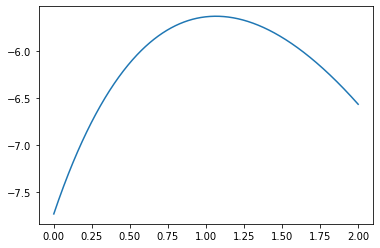

In [100]:
plt.plot(mu,Posterior)

In [101]:
ii = np.where( Posterior == np.amax(Posterior) )
muhat = mu[ii][0]
print(muhat)

1.0655325325325324


In [102]:
# Algoritmo de metropolis
n_walkers, n_params = 10,1
p0 = np.zeros((n_walkers,n_params))
p0[:,0] = 1
p0 += np.random.rand(n_walkers,n_params)
#p0

In [103]:
nll = lambda *p: LogPosterior(*p)
nll(0.2,data)

-6.920929635412291

In [104]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, nll, args=[data])
pos,prob,state,_ = sampler.run_mcmc(p0, 10000, progress = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1304.39it/s]


Text(0.5, 0, 'step number')

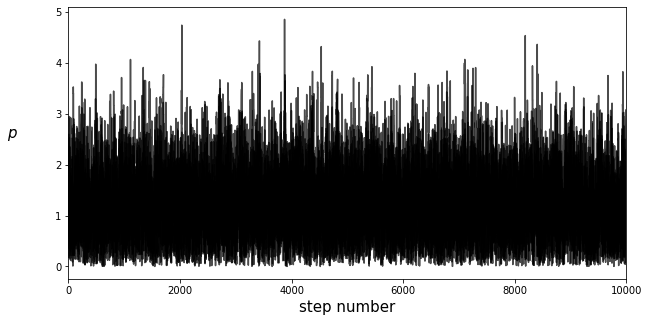

In [105]:
fig, axes = plt.subplots(n_params, figsize=(10, 5), sharex=True)

samples = sampler.get_chain()
labels = ["$p$"]

for i in range(n_params):
    #ax = axes[i]
    axes.plot(samples[:,:,i], "k", alpha=0.7)
    axes.set_xlim(0, len(samples))
    axes.set_ylabel(labels[i],rotation=0, fontsize=15)
    axes.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("step number",fontsize=15)

In [106]:
flat_samples = sampler.get_chain(discard=500, thin=20, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([1.18557166])

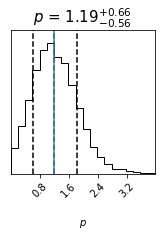

In [107]:
figure = corner.corner(flat_samples, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

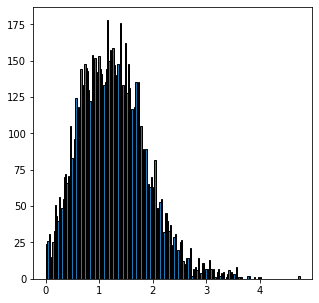

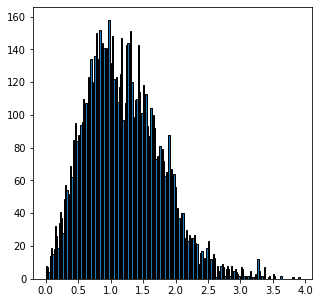

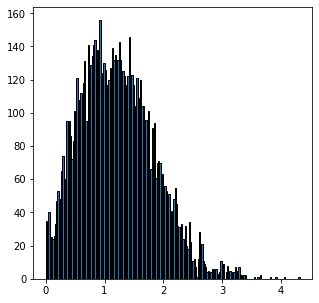

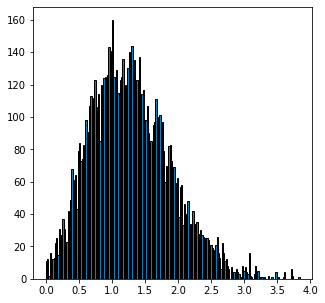

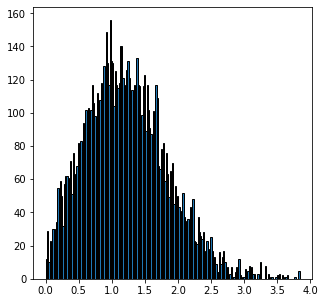

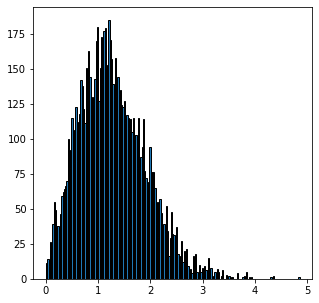

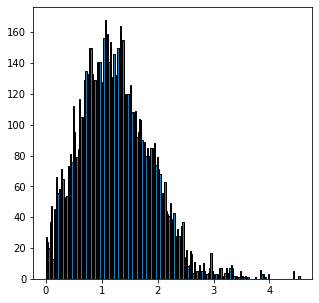

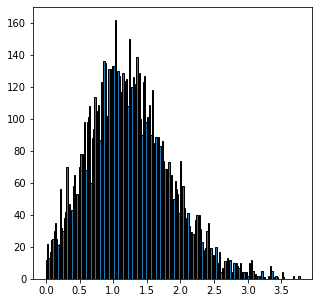

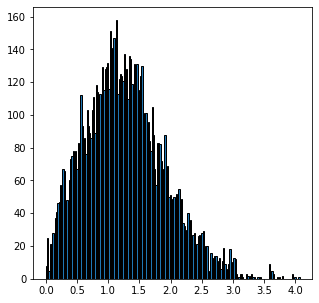

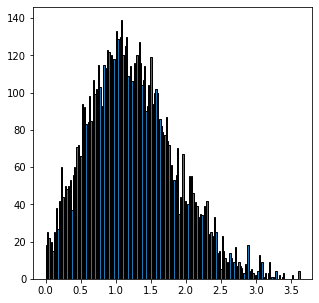

In [108]:
Modas = np.array([])
UpperLimits = np.array([])

for j in range(n_walkers):
    lista = samples[:,:,0][:,j]
    
    x = np.linspace(np.min(lista),np.max(lista),200)
    H,bins = np.histogram(lista,bins=x)
    w = np.diff(bins)
    
    #print(H)
    fig = plt.figure(figsize=(5,5))
    plt.bar(bins[:-1]+0.5*w[0],H,width=w,ec='k')
    
    # Intervalo de mayor frecuencia
    ii = np.where( H == np.amax(H) )
    i = ii[0][0]
    
    
    Li = bins[i]
    
    Moda = Li + w[0]*(  (H[i]-H[i-1])/(  (H[i]-H[i-1]) + (H[i]-H[i+1])  )   )
  #  print(Moda)
    Modas = np.append(Modas,Moda)
    UpperLimits = np.append(UpperLimits, np.percentile(lista,95))

In [109]:
Modas

array([1.16222837, 0.97537613, 0.9244663 , 1.01016883, 0.97846672,
       1.2137036 , 1.05712983, 1.03112081, 1.13134216, 1.08395199])

In [110]:
UpperLimits

array([2.32471851, 2.20953879, 2.28078   , 2.36258409, 2.30248655,
       2.40207469, 2.31910333, 2.29915048, 2.39635948, 2.31068472])

In [111]:
np.mean(Modas)

1.056795473895966

In [112]:
np.mean(UpperLimits)

2.3207480645458203

In [113]:
# Significancia
S = np.sum(s)
B = np.sum(b)
N = np.sum(n)
print(S,B,N)

7 12 19


In [114]:
S/np.sqrt(S+B)

1.6059101370939322